# Load the results into dataframes

In [1]:
# Load results, tidy columns, and prepare a unified dataframe
import os
import pandas as pd
path = "results/synthetic_data"
folders = ["results/synthetic_data/10%",
           "results/synthetic_data/25%",
           "results/synthetic_data/50%"
          ]
dfs = []
for subdir, dirs, files in os.walk(path+'/'):
    for file in files:
        if 'cfeval' in file:
            df = pd.read_csv(os.path.join(subdir,file))
            df['alphabet_coverage'] = subdir.split('/')[-1]
            dfs.append(df)
df1 = pd.concat(dfs)


path = "results/bpic2012_O_ACCEPTED-COMPLETE"
folders = ["results/bpic2012_O_ACCEPTED-COMPLETE/10%",
           "results/bpic2012_O_ACCEPTED-COMPLETE/25%",
           "results/bpic2012_O_ACCEPTED-COMPLETE/50%"
          ] 
dfs = []
for subdir, dirs, files in os.walk(path+'/'):
    for file in files:
        if 'cfeval' in file:
            df = pd.read_csv(os.path.join(subdir,file))
            df['alphabet_coverage'] = subdir.split('/')[-1]
            dfs.append(df)
df2 = pd.concat(dfs)



path = "results/BPIC17_O_ACCEPTED/"
folders = ["results/BPIC17_O_ACCEPTED/10%",
           "results/BPIC17_O_ACCEPTED/25%",
           "results/BPIC17_O_ACCEPTED/50%"
          ]
dfs = []
for subdir, dirs, files in os.walk(path+'/'):
    for file in files:
        if 'cfeval' in file:
            df = pd.read_csv(os.path.join(subdir,file))
            df['alphabet_coverage'] = subdir.split('/')[-1]
            dfs.append(df)
df3 = pd.concat(dfs)

df1.loc[df1['method'] == 'genetic_ltlf_baseline_operators', 'heuristic'] = 'genetic_ltlf_baseline_operators'
df2.loc[df2['method'] == 'genetic_ltlf_baseline_operators', 'heuristic'] = 'genetic_ltlf_baseline_operators'
df3.loc[df3['method'] == 'genetic_ltlf_baseline_operators', 'heuristic'] = 'genetic_ltlf_baseline_operators'

df1.loc[df1['heuristic'] == 'mar', 'heuristic'] = 'mutate_retry_baseline'
df2.loc[df2['heuristic'] == 'mar', 'heuristic'] = 'mutate_retry_baseline'
df3.loc[df3['heuristic'] == 'mar', 'heuristic'] = 'mutate_retry_baseline'

In [2]:
# Option to set number of decimals shown in pandas dataframes
pd.set_option("display.precision", 15)
pd.set_option("display.float_format", None)


# Calculate the ranks
This is done by executing Friedman and Wilcoxon tests per dataset x alphabet coverage x metric. These tests are able to detect if there are significant differences between the groups, and assign ranks based on these differences.

In [14]:
# Friedman and Wilcoxon tests per dataset x alphabet coverage x metric

import pandas as pd
from scipy.stats import friedmanchisquare, wilcoxon
import statsmodels.stats.multitest as smm
import numpy as np

# Assuming df1, df2, df3 are your DataFrames for the three datasets
dfs = [df1, df2, df3]
results = []

# Preprocess the data and calculate mean values for grouping
for i, df in enumerate(dfs, 1):
    df_groupby = df.groupby(['heuristic', 'prefix_length', 'desired_nr_of_cfs', 'alphabet_coverage']).mean(numeric_only=True).reset_index()
    df_groupby['dataset'] = df['dataset'].iloc[0]
    results.append(df_groupby)

# Combine all datasets into a single DataFrame
combined_df = pd.concat(results)
combined_df = combined_df.rename(columns={'sat_score':'conformance', 'distance_l2j':'distance', 
                                          'implausibility_sum':'implausibility', 'avg_nbr_changes_per_cf':'sparsity', 
                                          'diversity_l2j':'diversity'})
combined_df['hit_rate'] = combined_df['generated_cfs'] / combined_df['desired_nr_of_cfs']

# List of metrics
metrics = ['distance', 'sparsity', 'implausibility', 'conformance', 'diversity', 'hit_rate', 'runtime']

friedman_results = {}
pairwise_results = {}

# Perform tests for each dataset and alphabet_coverage
for dataset in combined_df['dataset'].unique():
    dataset_df = combined_df[combined_df['dataset'] == dataset]
    friedman_results[dataset] = {}
    pairwise_results[dataset] = {}

    for alphabet_coverage in dataset_df['alphabet_coverage'].unique():
        ac_df = dataset_df[dataset_df['alphabet_coverage'] == alphabet_coverage]
        friedman_results[dataset][alphabet_coverage] = {}
        pairwise_results[dataset][alphabet_coverage] = {}

        for metric in metrics:
            # Ensure uniqueness by grouping and averaging
            df_pivot = ac_df.groupby(['prefix_length', 'desired_nr_of_cfs', 'heuristic'])[metric].mean().unstack()

            # Drop rows with any NaN values to ensure equal N for all groups
            df_pivot = df_pivot.dropna()

            if len(df_pivot.columns) < 3:
                continue  # Skip if there are less than 2 methods to compare

            # Perform Friedman test
            stat, p_value = friedmanchisquare(*[df_pivot[method] for method in df_pivot.columns])
            friedman_results[dataset][alphabet_coverage][metric] = p_value

            if p_value < 0.05:
                heuristics = df_pivot.columns
                p_values = []
                pairs = []

                for i in range(len(heuristics)):
                    for j in range(i + 1, len(heuristics)):
                        h1 = heuristics[i]
                        h2 = heuristics[j]
                        data_h1 = df_pivot[h1]
                        data_h2 = df_pivot[h2]

                        if np.array_equal(data_h1, data_h2):
                            p_value = 1.0
                        else:
                            try:
                                # Perform Wilcoxon signed-rank test
                                stat, p_value = wilcoxon(data_h1, data_h2, zero_method='wilcox')
                            except ValueError:
                                p_value = np.nan
                        p_values.append(p_value)
                        pairs.append((h1, h2))

                # Perform multiple comparisons correction (e.g., Bonferroni correction)
                corrected_p_vals = smm.multipletests(p_values, alpha=0.05, method='bonferroni')[1]
                pairwise_results[dataset][alphabet_coverage][metric] = dict(zip(pairs, corrected_p_vals))

# Initialize a dictionary to store ranks
ranks = {dataset: {alphabet_coverage: {metric: {} for metric in metrics} 
                   for alphabet_coverage in combined_df['alphabet_coverage'].unique()} 
         for dataset in combined_df['dataset'].unique()}

# Assign ranks based on significant differences
for dataset in combined_df['dataset'].unique():
    for alphabet_coverage in combined_df['alphabet_coverage'].unique():
        dataset_ac_df = combined_df[(combined_df['dataset'] == dataset) & 
                                    (combined_df['alphabet_coverage'] == alphabet_coverage)]

        for metric in metrics:
            df_pivot = dataset_ac_df.groupby(['prefix_length', 'desired_nr_of_cfs', 'heuristic'])[metric].mean().unstack()
            df_pivot = df_pivot.dropna()

            if len(df_pivot.columns) < 3:
                continue  # Skip if there are less than 2 methods to compare

            methods = df_pivot.columns

            if friedman_results[dataset][alphabet_coverage][metric] < 0.05:
                for method in methods:
                    ranks[dataset][alphabet_coverage][metric][method] = 1  # Initial rank

                for (h1, h2), corrected_p_val in pairwise_results[dataset][alphabet_coverage][metric].items():
                    if corrected_p_val < 0.05:
                        if df_pivot[h1].mean() < df_pivot[h2].mean():
                            ranks[dataset][alphabet_coverage][metric][h2] += 1
                        else:
                            ranks[dataset][alphabet_coverage][metric][h1] += 1
            else:
                for method in methods:
                    ranks[dataset][alphabet_coverage][metric][method] = 1  # Same rank if no significant difference

# Create a DataFrame to store the ranks
rank_table = pd.DataFrame(columns=['dataset', 'metric', 'alphabet_coverage', 'heuristic', 'rank'])

# Populate the DataFrame with ranks
for dataset in combined_df['dataset'].unique():
    for alphabet_coverage in combined_df['alphabet_coverage'].unique():
        dataset_ac_df = combined_df[(combined_df['dataset'] == dataset) & 
                                    (combined_df['alphabet_coverage'] == alphabet_coverage)]
        for metric in metrics:
            df_pivot = dataset_ac_df.groupby(['prefix_length', 'desired_nr_of_cfs', 'heuristic'])[metric].mean().unstack()
            df_pivot = df_pivot.dropna()
            for (prefix_length, desired_nr_of_cfs), row in df_pivot.iterrows():
                for heuristic, value in row.items():
                    # added plus 2 changed to 3
                    rank_value = ranks.get(dataset, {}) \
                        .get(alphabet_coverage, {}) \
                        .get(metric, {}) \
                        .get(heuristic, 1)
                    
                    rank_table = rank_table.append({
                        'dataset': dataset,
                        'metric': metric,
                        'alphabet_coverage': alphabet_coverage,
                        'heuristic': heuristic,
                        # 'rank': ranks[dataset][alphabet_coverage][metric][heuristic]
                        'rank': rank_value
                    }, ignore_index=True)

# Pivot the rank_table to show ranks for each dataset, heuristic, metric, and alphabet coverage


c:\Users\Kyra Moviat\Documents\Vakken\Master\Year 2\Q1. Seminar Process Analytics\Replication\AAAI2025-temporal-constrained-counterfactuals\.venv\lib\site-packages\scipy\stats\_stats_py.py:9377: RuntimeWarning: invalid value encountered in double_scalars
  chisq = (12.0 / (k*n*(k+1)) * ssbn - 3*n*(k+1)) / c
c:\Users\Kyra Moviat\Documents\Vakken\Master\Year 2\Q1. Seminar Process Analytics\Replication\AAAI2025-temporal-constrained-counterfactuals\.venv\lib\site-packages\scipy\stats\_stats_py.py:9377: RuntimeWarning: invalid value encountered in double_scalars
  chisq = (12.0 / (k*n*(k+1)) * ssbn - 3*n*(k+1)) / c
c:\Users\Kyra Moviat\Documents\Vakken\Master\Year 2\Q1. Seminar Process Analytics\Replication\AAAI2025-temporal-constrained-counterfactuals\.venv\lib\site-packages\scipy\stats\_stats_py.py:9377: RuntimeWarning: invalid value encountered in double_scalars
  chisq = (12.0 / (k*n*(k+1)) * ssbn - 3*n*(k+1)) / c
c:\Users\Kyra Moviat\Documents\Vakken\Master\Year 2\Q1. Seminar Process A

In [15]:
# Create a table that shows the ranks for each dataset, heuristic, metric, and alphabet coverage
pivot_table = rank_table.pivot_table(index=['dataset', 'alphabet_coverage','metric'], columns='heuristic', values='rank')


In [16]:
# Inspect the columns of the pivot table
pivot_table.columns

Index(['genetic_ltlf_baseline_operators', 'heuristic_1', 'heuristic_2',
       'mutate_retry_baseline'],
      dtype='object', name='heuristic')

In [17]:
# Reorder the columns and display the pivot table
from IPython.core.display import HTML
pivot_table = pivot_table[['genetic_ltlf_baseline_operators','mutate_retry_baseline', 'heuristic_1',
       'heuristic_2']]
display(HTML(pivot_table.to_html()))

In [ ]:
# Execute Freidman and Wilcoxon tests per dataset x metric (so without alphabet coverage), then create a table that shows the ranks

# Assuming df1, df2, df3 are your DataFrames for the three datasets
dfs = [df1, df2, df3]
results = []
for i, df in enumerate(dfs, 1):
    df_groupby = df.groupby(['heuristic', 'prefix_length', 'desired_nr_of_cfs']).mean(numeric_only=True).reset_index()
    df_groupby['dataset'] = df['dataset'][1].unique()[0]
    results.append(df_groupby)


# Combine all datasets into a single DataFrame
combined_df = pd.concat(results)
combined_df = pd.concat(results)
combined_df = combined_df.rename(columns={'sat_score':'conformance','distance_l2j':'distance','implausibility_sum':'implausibility'
                                       ,'avg_nbr_changes_per_cf':'sparsity','diversity_l2j':'diversity'})
combined_df['hit_rate'] = combined_df['generated_cfs']/combined_df['desired_nr_of_cfs']
# List of metrics
metrics = ['distance', 'sparsity', 'implausibility', 'conformance', 'diversity', 'hit_rate', 'runtime']

friedman_results = {}
pairwise_results = {}

# Perform tests for each dataset
for dataset in combined_df['dataset'].unique():
    dataset_df = combined_df[combined_df['dataset'] == dataset]
    friedman_results[dataset] = {}
    pairwise_results[dataset] = {}

    for metric in metrics:
        df_pivot = dataset_df.pivot(index=['prefix_length', 'desired_nr_of_cfs'], columns='heuristic', values=metric)

        # Drop rows with any NaN values to ensure equal N for all groups
        df_pivot = df_pivot.dropna()

        if len(df_pivot.columns) < 3:
            continue  # Skip if there are less than 2 methods to compare

        # Perform Friedman test
        stat, p_value = friedmanchisquare(*[df_pivot[method] for method in df_pivot.columns])
        friedman_results[dataset][metric] = p_value

        if p_value < 0.05:
            heuristics = df_pivot.columns
            p_values = []
            pairs = []

            for i in range(len(heuristics)):
                for j in range(i + 1, len(heuristics)):
                    h1 = heuristics[i]
                    h2 = heuristics[j]
                    data_h1 = df_pivot[h1]
                    data_h2 = df_pivot[h2]

                    if np.array_equal(data_h1, data_h2):
                        p_value = 1.0
                    else:
                        # Perform Wilcoxon signed-rank test
                        try:
                            stat, p_value = wilcoxon(data_h1, data_h2, zero_method='wilcox')
                        except ValueError:
                            p_value = np.nan
                    p_values.append(p_value)
                    pairs.append((h1, h2))

            # Perform multiple comparisons correction (e.g., Bonferroni correction)
            corrected_p_vals = smm.multipletests(p_values, alpha=0.05, method='bonferroni')[1]
            pairwise_results[dataset][metric] = dict(zip(pairs, corrected_p_vals))

# Initialize a dictionary to store ranks
ranks = {dataset: {metric: {} for metric in metrics} for dataset in combined_df['dataset'].unique()}

# Assign ranks based on significant differences
for dataset in combined_df['dataset'].unique():
    dataset_df = combined_df[combined_df['dataset'] == dataset]

    for metric in metrics:
        df_pivot = dataset_df.pivot(index=['prefix_length', 'desired_nr_of_cfs'], columns='heuristic', values=metric)

        # Drop rows with any NaN values to ensure equal N for all groups
        df_pivot = df_pivot.dropna()

        if len(df_pivot.columns) < 3:
            continue  # Skip if there are less than 2 methods to compare

        methods = df_pivot.columns

        if friedman_results[dataset][metric] < 0.05:
            for method in methods:
                ranks[dataset][metric][method] = 1  # Initial rank

            for (h1, h2), corrected_p_val in pairwise_results[dataset][metric].items():
                if corrected_p_val < 0.05:
                    if df_pivot[h1].mean() < df_pivot[h2].mean():
                        ranks[dataset][metric][h2] += 1
                    else:
                        ranks[dataset][metric][h1] += 1
        else:
            for method in methods:
                ranks[dataset][metric][method] = 1  # Same rank if no significant difference

# Create a DataFrame to store the ranks
rank_table = pd.DataFrame(columns=['dataset', 'metric', 'heuristic', 'rank'])

# Populate the DataFrame with ranks
for dataset in ranks.keys():
    for metric in ranks[dataset].keys():
        for method, rank in ranks[dataset][metric].items():
            rank_table = rank_table.append({
                'dataset': dataset,
                'metric': metric,
                'heuristic': method,
                'rank': rank
            }, ignore_index=True)

# Pivot the rank_table to show ranks for each dataset, heuristic, and metric
pivot_table_2 = rank_table.pivot_table_2(index=['dataset', 'heuristic'], columns='metric', values='rank')

# Display the pivot table


c:\Users\Kyra Moviat\Documents\Vakken\Master\Year 2\Q1. Seminar Process Analytics\Replication\AAAI2025-temporal-constrained-counterfactuals\.venv\lib\site-packages\scipy\stats\_stats_py.py:9377: RuntimeWarning: invalid value encountered in double_scalars
  chisq = (12.0 / (k*n*(k+1)) * ssbn - 3*n*(k+1)) / c
c:\Users\Kyra Moviat\Documents\Vakken\Master\Year 2\Q1. Seminar Process Analytics\Replication\AAAI2025-temporal-constrained-counterfactuals\.venv\lib\site-packages\scipy\stats\_stats_py.py:9377: RuntimeWarning: invalid value encountered in double_scalars
  chisq = (12.0 / (k*n*(k+1)) * ssbn - 3*n*(k+1)) / c
c:\Users\Kyra Moviat\Documents\Vakken\Master\Year 2\Q1. Seminar Process Analytics\Replication\AAAI2025-temporal-constrained-counterfactuals\.venv\lib\site-packages\scipy\stats\_stats_py.py:9377: RuntimeWarning: invalid value encountered in double_scalars
  chisq = (12.0 / (k*n*(k+1)) * ssbn - 3*n*(k+1)) / c
C:\Users\Kyra Moviat\AppData\Local\Temp\ipykernel_19116\3208658604.py:109

In [ ]:
# Show table made in previous cell
pivot_table_2

metric                                                        conformance  \
dataset                      heuristic                                      
BPIC17_O_ACCEPTED            genetic_ltlf_baseline_operators          1.0   
                             heuristic_1                              1.0   
                             heuristic_2                              1.0   
                             mutate_retry_baseline                    1.0   
bpic2012_O_ACCEPTED-COMPLETE genetic_ltlf_baseline_operators          1.0   
                             heuristic_1                              1.0   
                             heuristic_2                              1.0   
                             mutate_retry_baseline                    1.0   
synthetic_data               genetic_ltlf_baseline_operators          1.0   
                             heuristic_1                              1.0   
                             heuristic_2                              1.0   
                             mutate_retry_baseline                    1.0   

metric                                                        distance  \
dataset                      heuristic                                   
BPIC17_O_ACCEPTED            genetic_ltlf_baseline_operators       3.0   
                             heuristic_1                           1.0   
                             heuristic_2                           2.0   
                             mutate_retry_baseline                 4.0   
bpic2012_O_ACCEPTED-COMPLETE genetic_ltlf_baseline_operators       1.0   
                             heuristic_1                           1.0   
                             heuristic_2                           1.0   
                             mutate_retry_baseline                 1.0   
synthetic_data               genetic_ltlf_baseline_operators       3.0   
                             heuristic_1                           1.0   
                             heuristic_2                           2.0   
                             mutate_retry_baseline                 4.0   

metric                                                        diversity  \
dataset                      heuristic                                    
BPIC17_O_ACCEPTED            genetic_ltlf_baseline_operators        2.0   
                             heuristic_1                            1.0   
                             heuristic_2                            2.0   
                             mutate_retry_baseline                  4.0   
bpic2012_O_ACCEPTED-COMPLETE genetic_ltlf_baseline_operators        1.0   
                             heuristic_1                            1.0   
                             heuristic_2                            1.0   
                             mutate_retry_baseline                  1.0   
synthetic_data               genetic_ltlf_baseline_operators        2.0   
                             heuristic_1                            1.0   
                             heuristic_2                            2.0   
                             mutate_retry_baseline                  4.0   

metric                                                        hit_rate  \
dataset                      heuristic                                   
BPIC17_O_ACCEPTED            genetic_ltlf_baseline_operators       1.0   
                             heuristic_1                           1.0   
                             heuristic_2                           1.0   
                             mutate_retry_baseline                 1.0   
bpic2012_O_ACCEPTED-COMPLETE genetic_ltlf_baseline_operators       1.0   
                             heuristic_1                           1.0   
                             heuristic_2                           1.0   
                             mutate_retry_baseline                 1.0   
synthetic_data               genetic_ltlf_baseline_operators       1.0   
                   

# Calculate the average performance metric per  dataset x alphabet coverage x heuristic

In [ ]:
import pandas as pd

# Combine the already-loaded per-dataset dataframes
dfs = [globals()[n] for n in ("df1", "df2", "df3") if n in globals() and isinstance(globals()[n], pd.DataFrame)]
if not dfs:
    raise RuntimeError("df1/df2/df3 not found. Run the earlier loading cells first.")
combined = pd.concat(dfs, ignore_index=True).copy()

# Standardize/alias metric column names so we can always find them. Only create a standardized column if it doesn't exist yet.
aliases = {
    "sat_score": "conformance",       
    "distance_l2j": "distance",
    "implausibility_sum": "implausibility",
    "avg_nbr_changes_per_cf": "sparsity",
    "diversity_l2j": "diversity",
    "runtime": "runtime",
}
for raw, std in aliases.items():
    if raw in combined.columns and std not in combined.columns:
        combined[std] = combined[raw]

# Hit rate if we have the ingredients
if {"generated_cfs", "desired_nr_of_cfs"}.issubset(combined.columns) and "hit_rate" not in combined.columns:
    combined["hit_rate"] = combined["generated_cfs"] / combined["desired_nr_of_cfs"]

# Pick the metrics to show (keep only those present)
metric_order = ["conformance", "distance", "diversity", "hit_rate", "implausibility", "sparsity", "runtime"]
metric_cols = [m for m in metric_order if m in combined.columns]
if not metric_cols:
    raise RuntimeError("No known metric columns found after standardization.")

# Compute the means per dataset × alphabet_coverage × heuristic
group_keys = ["dataset", "alphabet_coverage", "heuristic"]
missing_keys = [k for k in group_keys if k not in combined.columns]
if missing_keys:
    raise KeyError(f"Missing expected columns: {missing_keys}")

avg_df = (
    combined
    .groupby(group_keys, as_index=False)[metric_cols]
    .mean(numeric_only=True)
)

# Reshape to match the rank table structure
avg_pivot = (
    avg_df
    .melt(id_vars=group_keys, value_vars=metric_cols,
          var_name="metric", value_name="avg_value")
    .pivot_table(index=["dataset", "alphabet_coverage", "metric"],
                 columns="heuristic", values="avg_value")
    .sort_index(level=["dataset", "alphabet_coverage", "metric"])
)

# Display nicely
with pd.option_context("display.float_format", lambda x: f"{x:.3f}"):
    display(avg_pivot)


heuristic                                                      genetic_ltlf_baseline_operators  \
dataset                      alphabet_coverage metric                                            
BPIC17_O_ACCEPTED            10%               conformance                               0.992   
                                               distance                                  0.681   
                                               diversity                                 0.643   
                                               hit_rate                                  1.000   
                                               implausibility                            8.613   
                                               runtime                                  39.998   
                                               sparsity                                  8.108   
                             25%               conformance                               0.996   
                                               distance                                  0.683   
                                               diversity                                 0.627   
                                               hit_rate                                  1.000   
                                               implausibility                            8.658   
                                               runtime                                  45.813   
                                               sparsity                                  8.161   
bpic2012_O_ACCEPTED-COMPLETE 10%               conformance                               1.000   
                                               distance                                  0.490   
                                               diversity                                 0.463   
                                               hit_rate                                  1.000   
                                               implausibility                            6.619   
                                               runtime                                  10.176   
                                               sparsity                                  5.143   
                             25%               conformance                               0.988   
                                               distance                                  0.198   
                                               diversity                                 0.228   
                                               hit_rate                                  1.000   
                                               implausibility                            3.087   
                                               runtime                                1842.167   
                                               sparsity                                  2.074   
synthetic_data               10%               conformance                               0.988   
                                               distance                                  0.444   
                                               diversity                                 0.451   
                                               hit_rate                                  1.000   
                                               implausibility                            6.595   
                                               runtime                                   5.780   
                                               sparsity                                  2.292   
                             25%               conformance                               0.992   
                                               distance                                  0.465   
                                               diversity                                 0.449   
                                               hit_rate                         

# Combined rank and value table

In [ ]:
import pandas as pd

# Grab the two pivots 
avgs  = avg_pivot.copy()        
ranks = pivot_table.copy() 

# Outer-align to handle any mismatches (missing rows/cols in either)
avgs, ranks = avgs.align(ranks, join="outer", axis=None)

# Build a string table "avg (rank)" with nice formatting
def _fmt_cell(a, r, ndigits=3):
    a_nan = pd.isna(a)
    r_nan = pd.isna(r)
    if a_nan and r_nan:
        return None
    if a_nan and not r_nan:
        # Only rank available
        try:
            ri = int(round(float(r)))
        except Exception:
            ri = r
        return f"- ({ri})"
    if not a_nan and r_nan:
        # Only average available
        return f"{a:.{ndigits}f} (-)"
    # Both present
    try:
        ri = int(round(float(r)))
    except Exception:
        ri = r
    return f"{a:.{ndigits}f} ({ri})"

combined = avgs.astype(object).copy()
for idx in avgs.index:
    for col in avgs.columns:
        combined.at[idx, col] = _fmt_cell(avgs.at[idx, col], ranks.at[idx, col])

# Sort for neatness
combined = combined.sort_index(level=["dataset", "alphabet_coverage", "metric"])

# Display
display(combined)


heuristic                                                     genetic_ltlf_baseline_operators  \
dataset                      alphabet_coverage metric                                           
BPIC17_O_ACCEPTED            10%               conformance                          0.992 (1)   
                                               distance                             0.681 (3)   
                                               diversity                            0.643 (1)   
                                               hit_rate                             1.000 (1)   
                                               implausibility                       8.613 (2)   
                                               runtime                             39.998 (1)   
                                               sparsity                             8.108 (3)   
                             25%               conformance                          0.996 (1)   
                                               distance                             0.683 (3)   
                                               diversity                            0.627 (2)   
                                               hit_rate                             1.000 (1)   
                                               implausibility                       8.658 (3)   
                                               runtime                             45.813 (1)   
                                               sparsity                             8.161 (3)   
bpic2012_O_ACCEPTED-COMPLETE 10%               conformance                          1.000 (1)   
                                               distance                             0.490 (1)   
                                               diversity                            0.463 (1)   
                                               hit_rate                             1.000 (1)   
                                               implausibility                       6.619 (1)   
                                               runtime                             10.176 (1)   
                                               sparsity                             5.143 (1)   
                             25%               conformance                          0.988 (1)   
                                               distance                             0.198 (1)   
                                               diversity                            0.228 (1)   
                                               hit_rate                             1.000 (1)   
                                               implausibility                       3.087 (1)   
                                               runtime                           1842.167 (1)   
                                               sparsity                             2.074 (1)   
synthetic_data               10%               conformance                          0.988 (1)   
                                               distance                             0.444 (2)   
                                               diversity                            0.451 (1)   
                                               hit_rate                             1.000 (1)   
                                               implausibility                       6.595 (1)   
                                               runtime                              5.780 (1)   
                                               sparsity                             2.292 (2)   
                             25%               conformance                          0.992 (1)   
                                               distance                             0.465 (3)   
                                               diversity                            0.449 (1)   
                                               hit_rate                             1.000 (1)   
                       

# Dataset wise boxplot results

Text(0.07, 0.73, 'Claim Management')

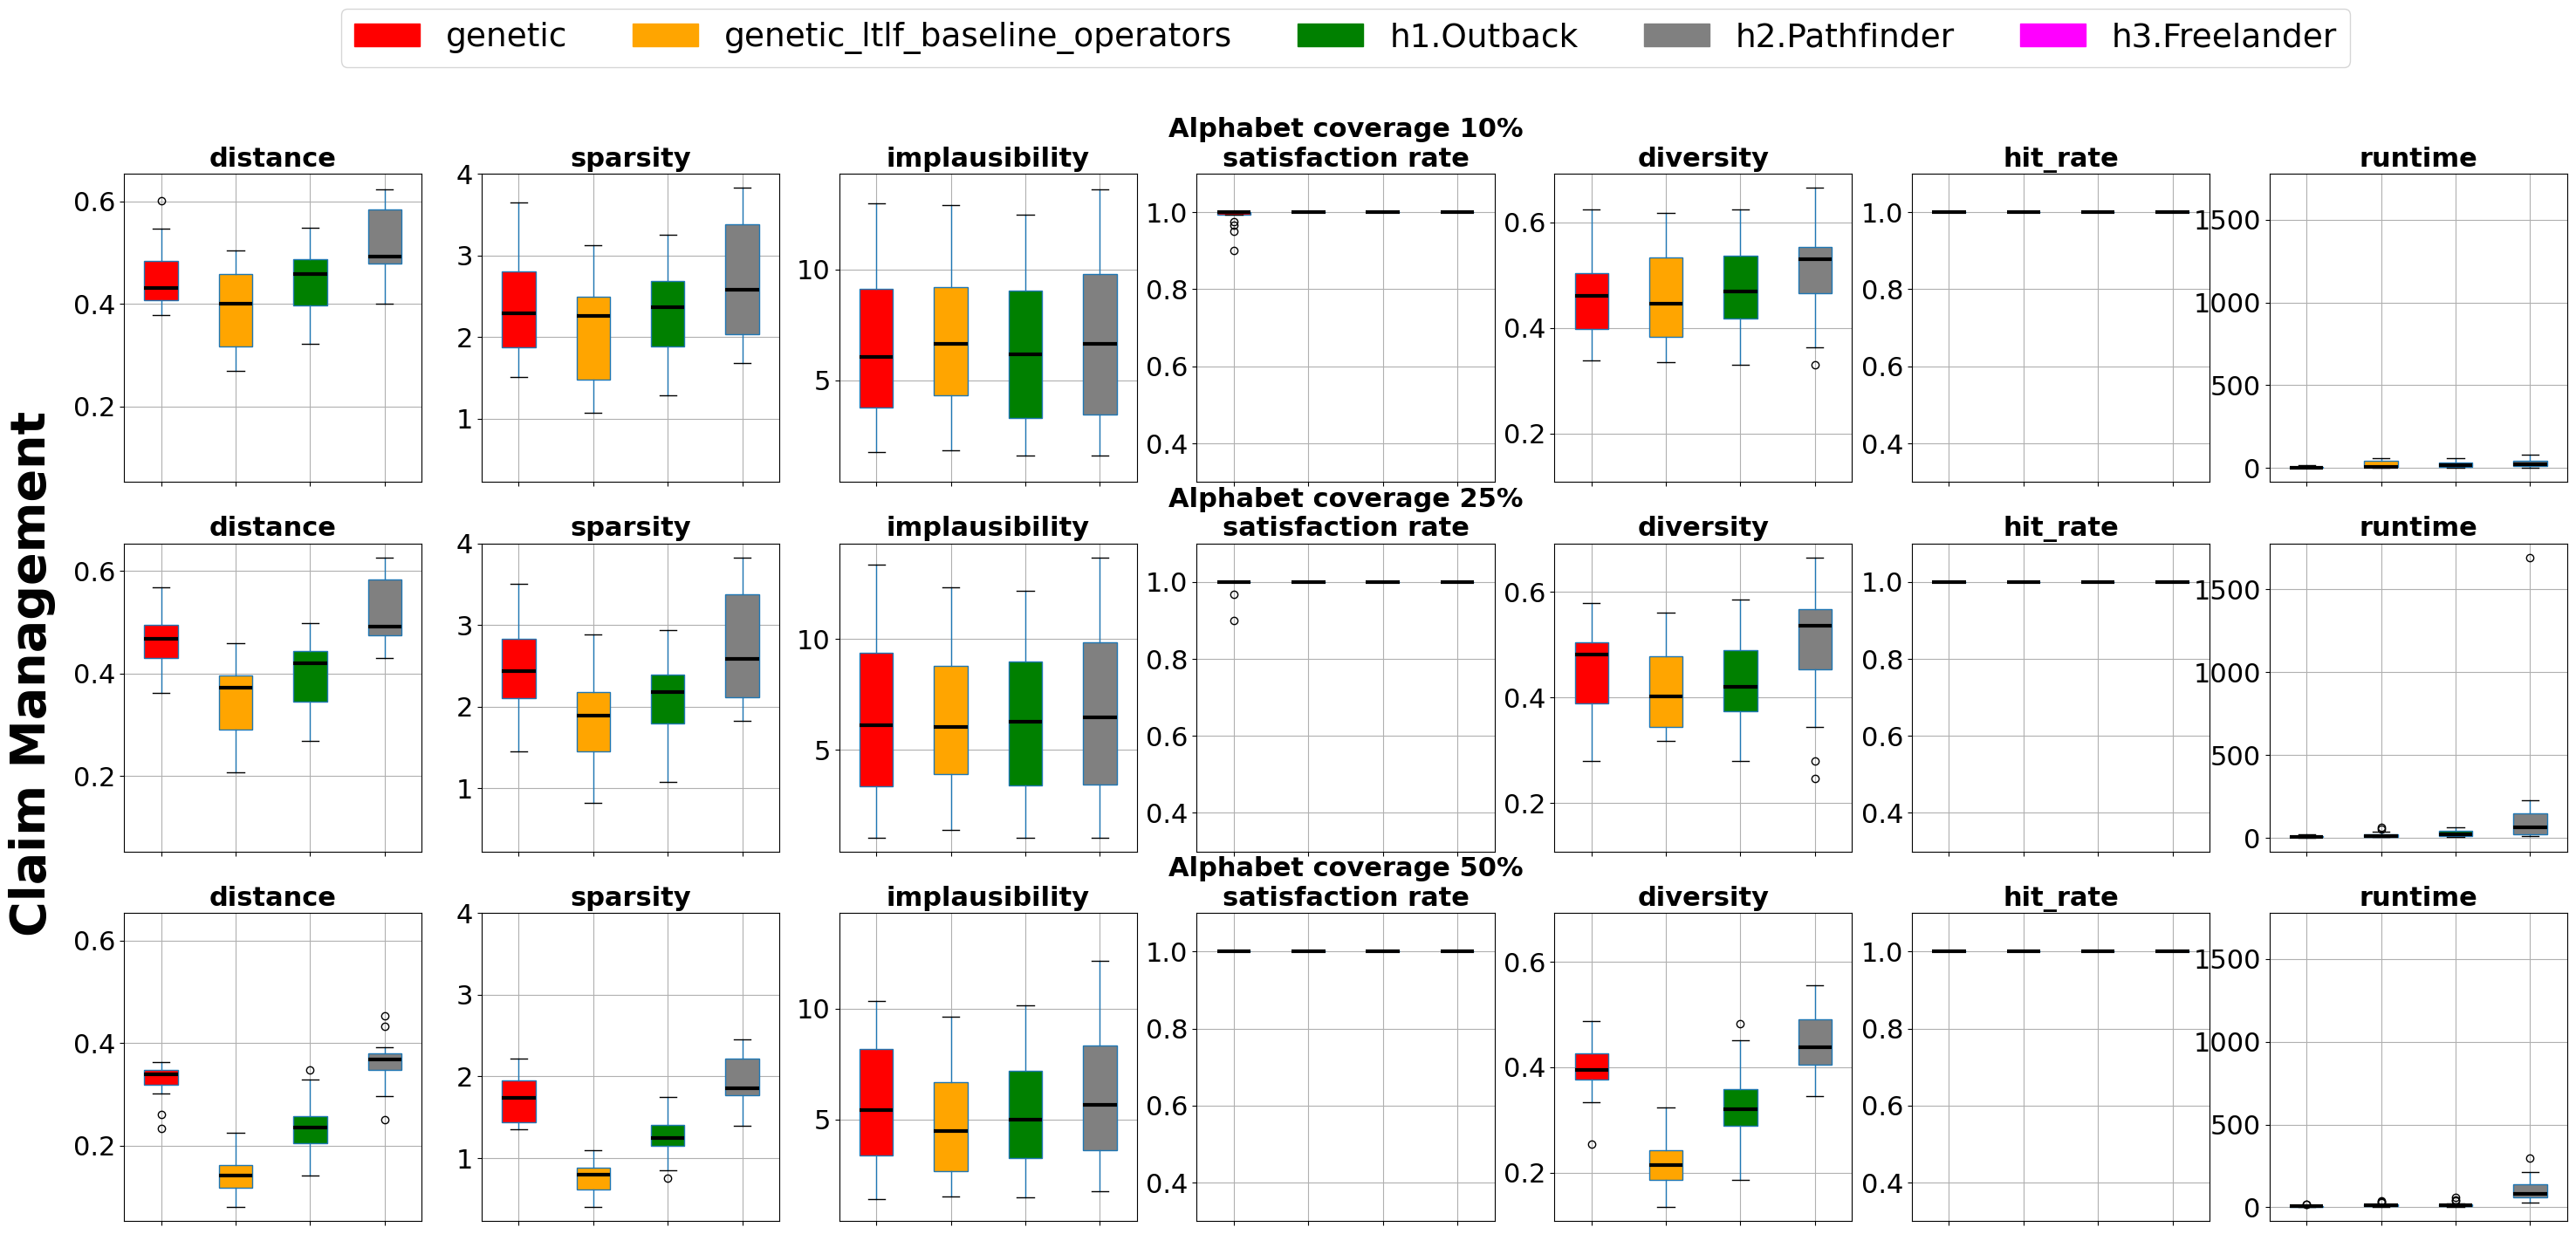

In [10]:
import matplotlib.patches as mpatches
import os
import pandas as pd
import matplotlib.pyplot as plt
path = "results/synthetic_data"
folders = ["results/synthetic_data/10%",
           "results/synthetic_data/25%",
           "results/synthetic_data/50%"]
dfs = []
for subdir, dirs, files in os.walk(path+'/'):
    for file in files:
        if 'cfeval' in file:
            df = pd.read_csv(os.path.join(subdir,file))
            df['alphabet_coverage'] = subdir.split('/')[-1]
            dfs.append(df)
final_df = pd.concat(dfs)


prefixes = [7,9,11,13]
df = final_df
# Update 'heuristic' column where 'method' is 'genetic'
df.loc[df['method'] == 'genetic_ltlf_baseline_operators', 'heuristic'] = 'genetic_ltlf_baseline_operators'

# Update 'heuristic' column where 'method' is 'random'

df = df[df['prefix_length'].isin(prefixes)]
df = df.rename(columns={'sat_score':'trace fitness','distance_l2j':'distance','implausibility_sum':'implausibility'
                                       ,'avg_nbr_changes_per_cf':'sparsity','diversity_l2j':'diversity'})
all_data = df
all_data['hit_rate'] = all_data['generated_cfs']/all_data['desired_nr_of_cfs']

rows = 0 
coverages = ["10%","25%","50%"]
fig_1, axes = plt.subplots(nrows=len(coverages), ncols=7, figsize=(35, 16),sharey='col')

for coverage in coverages:
    df = all_data[all_data['alphabet_coverage'].str.contains(coverage)]
    #df['optimization'].replace({'multiobjective_adapted':'AOMO','multiobjective_baseline':'BOMO',
    #                           'single_adapted':'AOSO','single_baseline':'BOSO'},inplace=True)
    df = df[
        ['heuristic','prefix_length','desired_nr_of_cfs','distance', 'sparsity','implausibility','trace fitness','diversity','hit_rate','runtime']]
    df_groupby = df.groupby(['heuristic', 'prefix_length','desired_nr_of_cfs']).mean(numeric_only=True)
    # crate the figure and axes
    #df_groupby.iloc[-32:-16,-1] *= 0.3
    for j, i in enumerate(df_groupby.columns):
        #df_groupby[[i]].unstack(level=0).plot(ax=axes[rows][j], legend=None, title=i,linewidth=5.0,
        #                                      style=['--', '-', '--','-'],
                                              #cmap="Accent",
        #                                      fontsize=18,color=['red','orange','green','blue']
        #                                  )
        medianprops = dict(linewidth=3, color='black')
        bplot = df_groupby[[i]].boxplot(by='heuristic',ax=axes[rows][j], #legend=None, title=i,#,linewidth=5.0,
                                      #style=['--', '-', '--','-'],
                                      #cmap="Accent",
                                      patch_artist=True,fontsize=18,medianprops=medianprops,
                                         return_type='both'#,color=['red','orange','green','blue']
                                  )
        colors=['red','orange','green','gray','magenta']
        for row_key, (ax,row) in bplot.items():
            ax.set_xlabel('')
            for i,box in enumerate(row['boxes']):
                box.set_facecolor(colors[i])


    for ax in axes.flatten():
        ax.yaxis.set_tick_params(labelleft=True,labelsize=22)
        ax.set(xlabel=None)
        ax.set(xticklabels=[])
        ax.set_title(label=ax.title._text,fontsize=22,fontweight='bold')
    axes[rows,3].set_title("Alphabet coverage "+coverage+"\n"+'satisfaction rate',fontweight="bold",size=22)
    axes[rows,3].set_ylim(0.3,1.1)
    axes[rows,5].set_ylim(0.3,1.1)

    rows += 1
red_patch = mpatches.Patch(color='red', label='genetic',)
orange_patch = mpatches.Patch(color='orange', label='genetic_ltlf_baseline_operators')
green_patch = mpatches.Patch(color='green', label='h1.Outback')
#blue_patch = mpatches.Patch(color='blue', label='h2.Highlander')
gray_patch = mpatches.Patch(color='gray', label='h2.Pathfinder')
magenta_patch = mpatches.Patch(color='magenta', label='h3.Freelander')
fig_1.legend(handles=[red_patch,orange_patch,green_patch,gray_patch,magenta_patch],loc='upper center',
        bbox_to_anchor=(0.5, 1.03),
        ncol=6,prop={"size":27},fontsize=40)
fig_1.suptitle('Claim Management',x=0.07,y=0.73,fontsize=40,fontweight='bold',rotation=90)
#fig_1.savefig('/Users/andrei/Desktop/PhD/boxplots_overall_ecai_paper_synthetic_log.png', bbox_inches='tight')


ValueError: not enough values to unpack (expected 2, got 0)

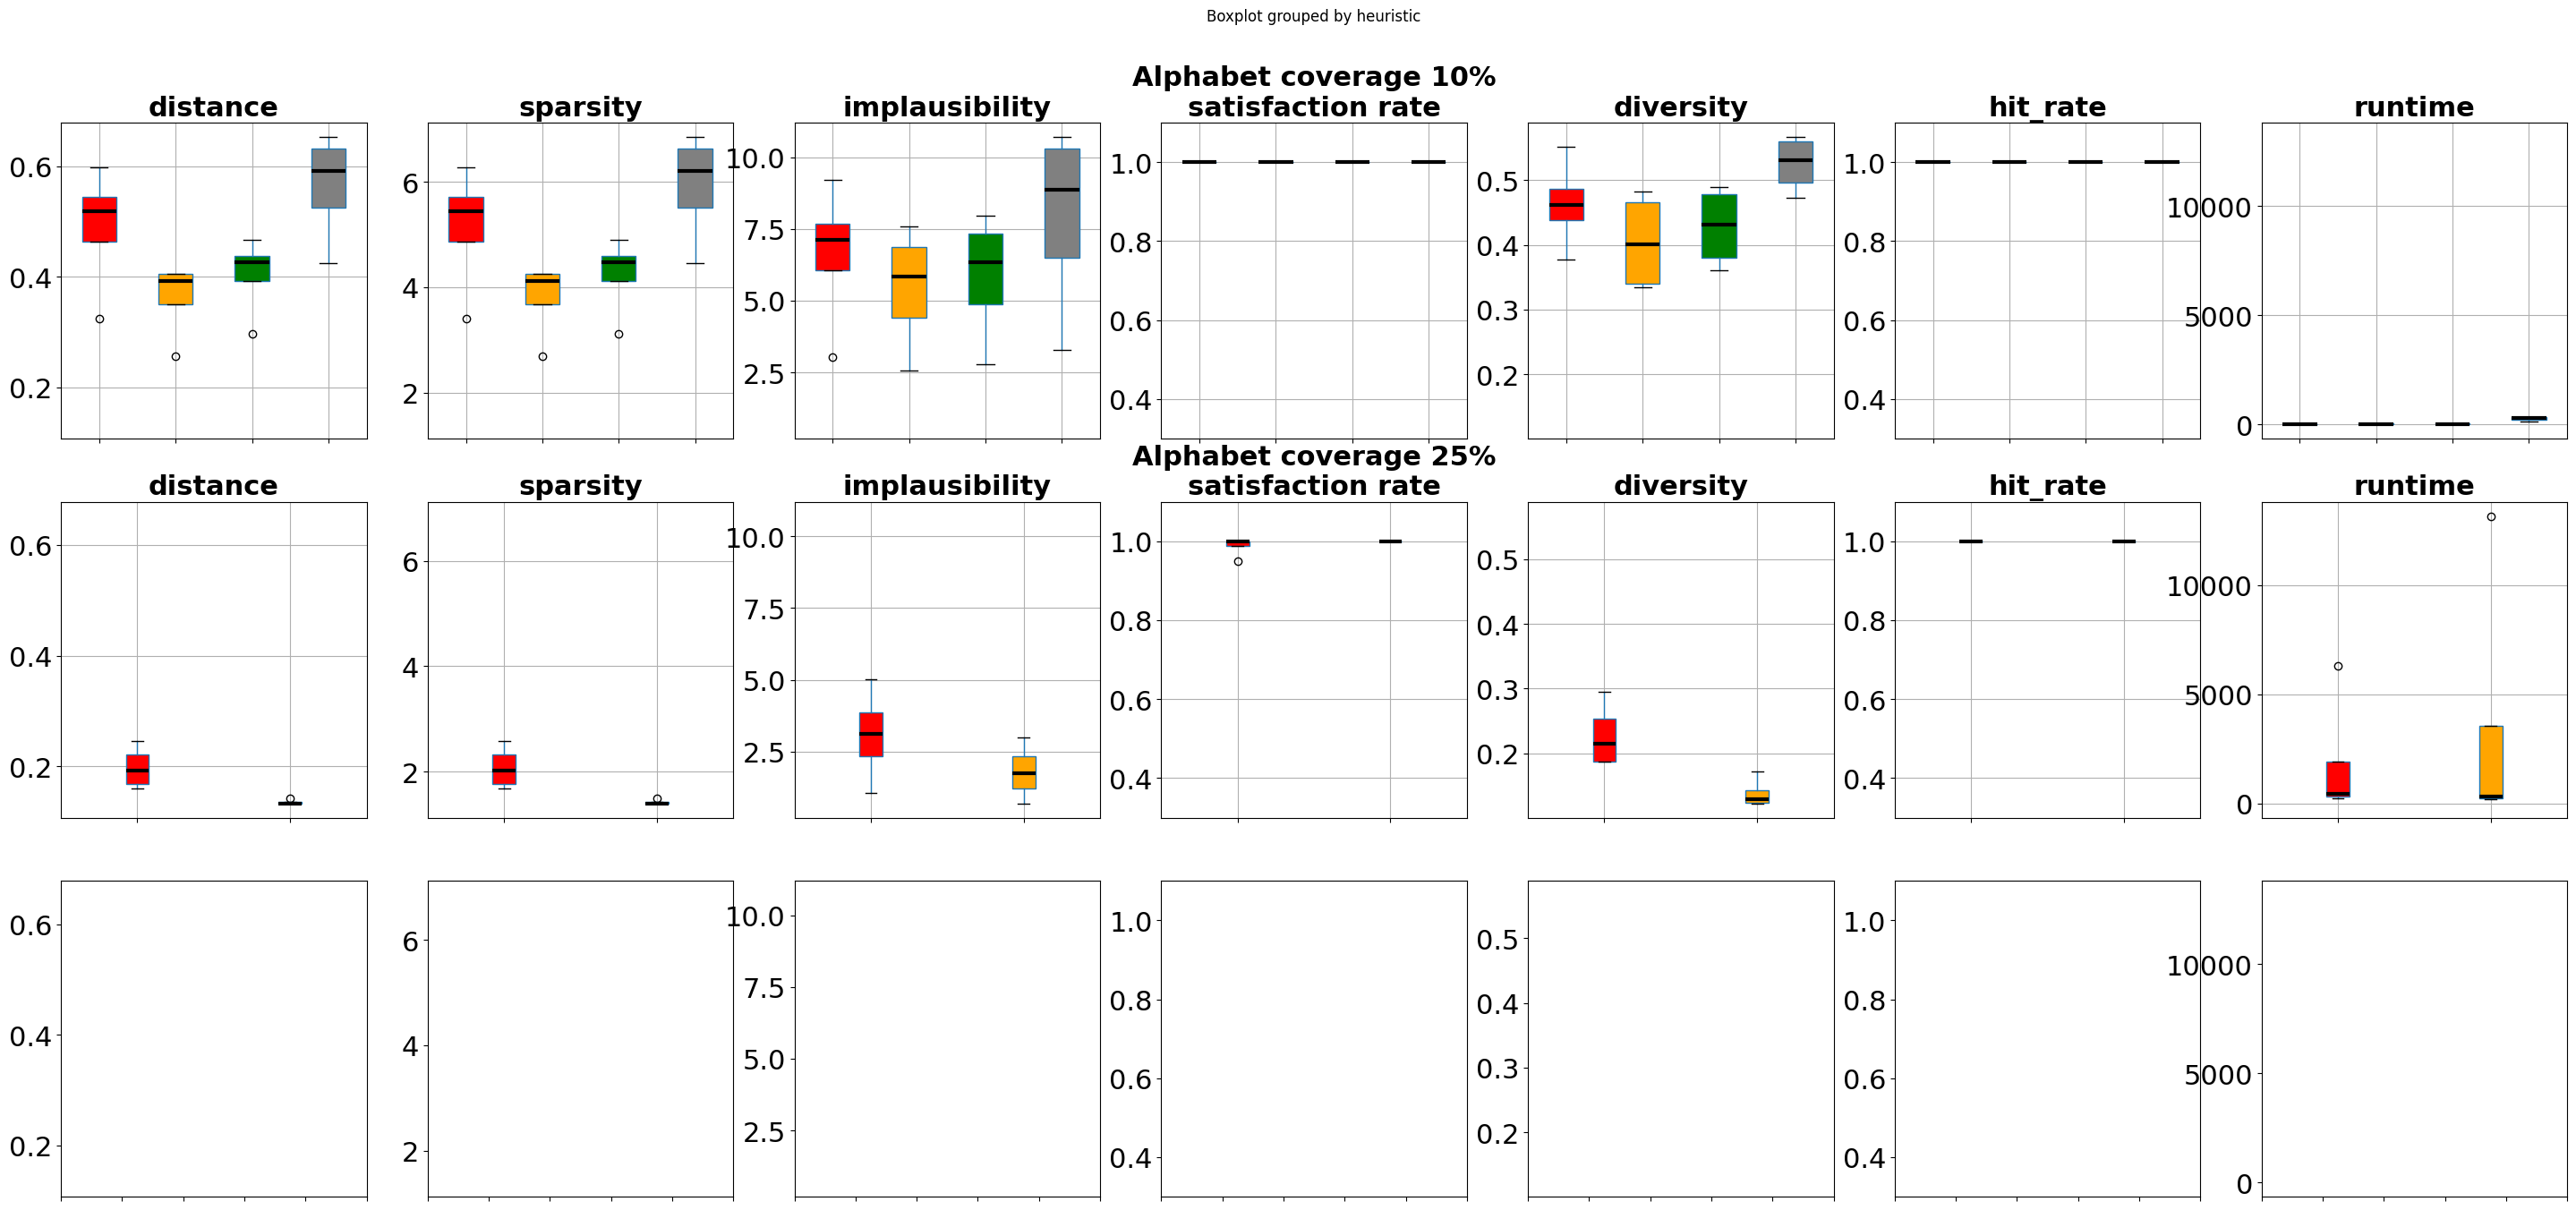

In [11]:
import matplotlib.patches as mpatches
import os
import pandas as pd
import matplotlib.pyplot as plt
path = "results/bpic2012_O_ACCEPTED-COMPLETE"
folders = ["results/bpic2012_O_ACCEPTED-COMPLETE/10%",
           "results/bpic2012_O_ACCEPTED-COMPLETE/25%",
           "results/bpic2012_O_ACCEPTED-COMPLETE/50%"
          ]
dfs = []
for subdir, dirs, files in os.walk(path+'/'):
    if subdir in folders:
        for file in files:
                if 'cfeval' in file:
                        df = pd.read_csv(os.path.join(subdir,file))
                        df['alphabet_coverage'] = subdir.split('/')[-1]
                        dfs.append(df)
final_df = pd.concat(dfs)


prefixes = [20,25,30,35]
df = final_df
# Update 'heuristic' column where 'method' is 'genetic'
df.loc[df['method'] == 'genetic_ltlf_baseline_operators', 'heuristic'] = 'genetic_ltlf_baseline_operators'

df = df[df['prefix_length'].isin(prefixes)]
df = df.rename(columns={'sat_score':'trace fitness','distance_l2j':'distance','implausibility_sum':'implausibility'
                                       ,'avg_nbr_changes_per_cf':'sparsity','diversity_l2j':'diversity'})
all_data = df
all_data['hit_rate'] = all_data['generated_cfs']/all_data['desired_nr_of_cfs']

rows = 0 
coverages = ["10%","25%",
             "50%"
            ]
fig_1, axes = plt.subplots(nrows=len(coverages), ncols=7, figsize=(35, 16),sharey='col')

for coverage in coverages:
    df = all_data[all_data['alphabet_coverage'].str.contains(coverage)]
    #df['optimization'].replace({'multiobjective_adapted':'AOMO','multiobjective_baseline':'BOMO',
    #                           'single_adapted':'AOSO','single_baseline':'BOSO'},inplace=True)
    df = df[
        ['heuristic','prefix_length','desired_nr_of_cfs','distance', 'sparsity','implausibility','trace fitness','diversity','hit_rate','runtime']]
    df_groupby = df.groupby(['heuristic', 'prefix_length','desired_nr_of_cfs']).mean(numeric_only=True)
    # crate the figure and axes
    #df_groupby.iloc[-32:-16,-1] *= 0.3
    for j, i in enumerate(df_groupby.columns):
        #df_groupby[[i]].unstack(level=0).plot(ax=axes[rows][j], legend=None, title=i,linewidth=5.0,
        #                                      style=['--', '-', '--','-'],
                                              #cmap="Accent",
        #                                      fontsize=18,color=['red','orange','green','blue']
        #                                  )
        medianprops = dict(linewidth=3, color='black')
        bplot = df_groupby[[i]].boxplot(by='heuristic',ax=axes[rows][j], #legend=None, title=i,#,linewidth=5.0,
                                      #style=['--', '-', '--','-'],
                                      #cmap="Accent",
                                      patch_artist=True,fontsize=18,medianprops=medianprops,
                                         return_type='both'#,color=['red','orange','green','blue']
                                  )
        colors=['red','orange','green','gray','magenta']
        for row_key, (ax,row) in bplot.items():
            ax.set_xlabel('')
            for i,box in enumerate(row['boxes']):
                box.set_facecolor(colors[i])


    for ax in axes.flatten():
        ax.yaxis.set_tick_params(labelleft=True,labelsize=22)
        ax.set(xlabel=None)
        ax.set(xticklabels=[])
        ax.set_title(label=ax.title._text,fontsize=22,fontweight='bold')
    axes[rows,3].set_title("Alphabet coverage "+coverage+"\n"+'satisfaction rate',fontweight="bold",size=22)
    axes[rows,3].set_ylim(0.3,1.1)
    axes[rows,5].set_ylim(0.3,1.1)

    rows += 1
red_patch = mpatches.Patch(color='red', label='genetic',)
orange_patch = mpatches.Patch(color='orange', label='genetic_ltlf_baseline_operators')
green_patch = mpatches.Patch(color='green', label='h1.Outback')
#blue_patch = mpatches.Patch(color='blue', label='h2.Highlander')
gray_patch = mpatches.Patch(color='gray', label='h2.Pathfinder')
magenta_patch = mpatches.Patch(color='magenta', label='h3.Freelander')
fig_1.legend(handles=[red_patch,orange_patch,green_patch,gray_patch,magenta_patch],loc='upper center',
        bbox_to_anchor=(0.5, 1.03),
        ncol=6,prop={"size":27},fontsize=40)
fig_1.suptitle('BPIC2012',x=0.07,y=0.73,fontsize=40,fontweight='bold',rotation=90)
#fig_1.savefig('/Users/andrei/Desktop/PhD/boxplots_overall_ecai_paper_synthetic_log.png', bbox_inches='tight')


ValueError: not enough values to unpack (expected 2, got 0)

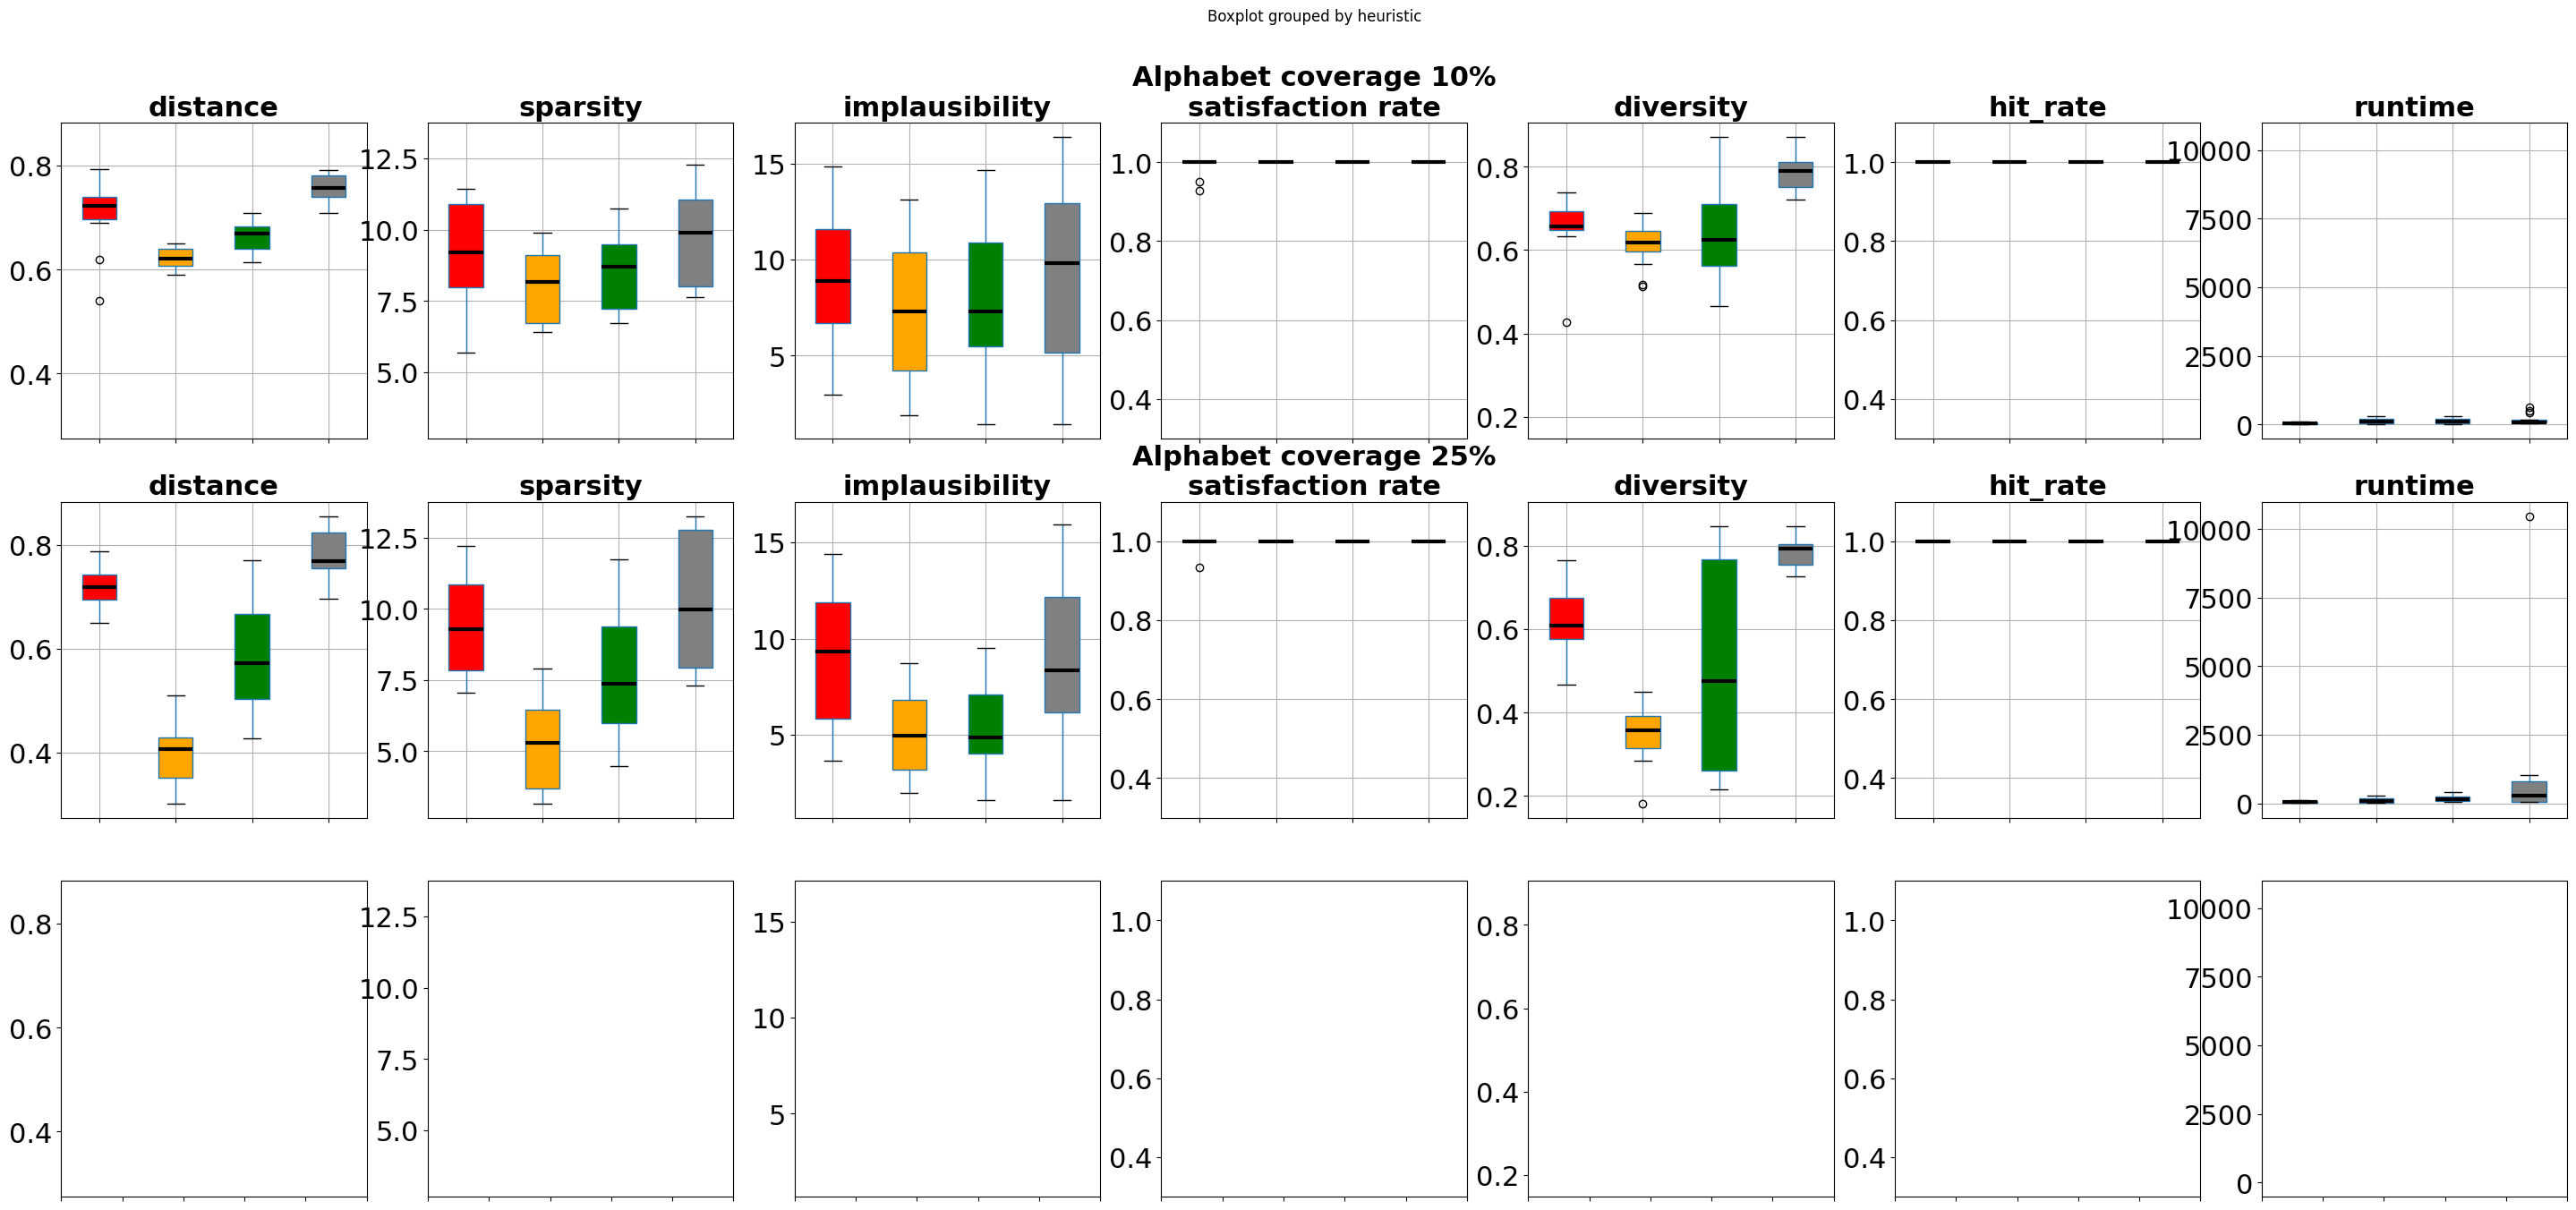

In [ ]:
import matplotlib.patches as mpatches
import os
import pandas as pd
import matplotlib.pyplot as plt
path = "results/BPIC17_O_ACCEPTED"
folders = ["results/BPIC17_O_ACCEPTED/10%",
           "results/BPIC17_O_ACCEPTED/25%",
           "results/BPIC17_O_ACCEPTED/50%"
          ]
dfs = []
for subdir, dirs, files in os.walk(path+'/'):
    if subdir in folders:
        for file in files:
                if 'cfeval' in file:
                        df = pd.read_csv(os.path.join(subdir,file))
                        df['alphabet_coverage'] = subdir.split('/')[-1]
                        dfs.append(df)
final_df = pd.concat(dfs)


prefixes = [20,25,30,35]
df = final_df
# Update 'heuristic' column where 'method' is 'genetic'
df.loc[df['method'] == 'genetic_ltlf_baseline_operators', 'heuristic'] = 'genetic_ltlf_baseline_operators'
# Update 'heuristic' column where 'method' is 'random'

df = df[df['prefix_length'].isin(prefixes)]
df = df.rename(columns={'sat_score':'trace fitness','distance_l2j':'distance','implausibility_sum':'implausibility'
                                       ,'avg_nbr_changes_per_cf':'sparsity','diversity_l2j':'diversity'})
all_data = df
all_data['hit_rate'] = all_data['generated_cfs']/all_data['desired_nr_of_cfs']

rows = 0 
coverages = ["10%","25%",
             "50%"
            ]
fig_1, axes = plt.subplots(nrows=len(coverages), ncols=7, figsize=(35, 16),sharey='col')

for coverage in coverages:
    df = all_data[all_data['alphabet_coverage'].str.contains(coverage)]
    #df['optimization'].replace({'multiobjective_adapted':'AOMO','multiobjective_baseline':'BOMO',
    #                           'single_adapted':'AOSO','single_baseline':'BOSO'},inplace=True)
    df = df[
        ['heuristic','prefix_length','desired_nr_of_cfs','distance', 'sparsity','implausibility','trace fitness','diversity','hit_rate','runtime']]
    df_groupby = df.groupby(['heuristic', 'prefix_length','desired_nr_of_cfs']).mean(numeric_only=True)
    # crate the figure and axes
    #df_groupby.iloc[-32:-16,-1] *= 0.3
    for j, i in enumerate(df_groupby.columns):
        #df_groupby[[i]].unstack(level=0).plot(ax=axes[rows][j], legend=None, title=i,linewidth=5.0,
        #                                      style=['--', '-', '--','-'],
                                              #cmap="Accent",
        #                                      fontsize=18,color=['red','orange','green','blue']
        #                                  )
        medianprops = dict(linewidth=3, color='black')
        bplot = df_groupby[[i]].boxplot(by='heuristic',ax=axes[rows][j], #legend=None, title=i,#,linewidth=5.0,
                                      #style=['--', '-', '--','-'],
                                      #cmap="Accent",
                                      patch_artist=True,fontsize=18,medianprops=medianprops,
                                         return_type='both'#,color=['red','orange','green','blue']
                                  )
        colors=['red','orange','green','gray','magenta']
        for row_key, (ax,row) in bplot.items():
            ax.set_xlabel('')
            for i,box in enumerate(row['boxes']):
                box.set_facecolor(colors[i])


    for ax in axes.flatten():
        ax.yaxis.set_tick_params(labelleft=True,labelsize=22)
        ax.set(xlabel=None)
        ax.set(xticklabels=[])
        ax.set_title(label=ax.title._text,fontsize=22,fontweight='bold')
    axes[rows,3].set_title("Alphabet coverage "+coverage+"\n"+'satisfaction rate',fontweight="bold",size=22)
    axes[rows,3].set_ylim(0.3,1.1)
    axes[rows,5].set_ylim(0.3,1.1)

    rows += 1
red_patch = mpatches.Patch(color='red', label='genetic',)
orange_patch = mpatches.Patch(color='orange', label='genetic_ltlf_baseline_operators')
green_patch = mpatches.Patch(color='green', label='h1.Outback')
#blue_patch = mpatches.Patch(color='blue', label='h2.Highlander')
gray_patch = mpatches.Patch(color='gray', label='h2.Pathfinder')
magenta_patch = mpatches.Patch(color='magenta', label='h3.Freelander')
fig_1.legend(handles=[red_patch,orange_patch,green_patch,gray_patch,magenta_patch],loc='upper center',
        bbox_to_anchor=(0.5, 1.03),
        ncol=6,prop={"size":27},fontsize=40)
fig_1.suptitle('BPIC17_O_ACCEPTED',x=0.07,y=0.73,fontsize=40,fontweight='bold',rotation=90)
#fig_1.savefig('/Users/andrei/Desktop/PhD/boxplots_overall_ecai_paper_synthetic_log.png', bbox_inches='tight')
